In [53]:
settings = {
    "xsrf_cookies": False,
}

In [2]:
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import numpy as np

#load data labels and RDkit fingerprints
#using pickled data
with open('../dumps/combined_dataset.pkl', 'rb') as f:
      data = pickle.load(f)

N=len(data.loc[data['target'] == 'TMPRSS2']) #number of compounds tested against TMPRSS2 itself
n_test=round(N/3) #withold for testing
fp_dark=np.load('../dumps/DarkChemicalMatter_morgan_fingerprints.npz')
fp_dark=fp_dark['fps']


In [32]:
#convert to array
#using merged data from pickle
datalabels=list(data['target'])
fps_merged=np.stack(data['morgan_fingerprint'])
ac_merged_scaled=np.asarray(data['acvalue_scaled_to_tmprss2'])
cids=list(data['cid'])
act_list=list(data['activity_target'])
activity_scaled=[]
activity=[]
for i in range(len(act_list)):
    if act_list[i] == 'Active':
        activity.append(1)
    else:
        activity.append(0)
    if ac_merged_scaled[i]>0:
        if act_list[i] == 'Active':
            activity_scaled.append(1)
        else:
            activity_scaled.append(0)
#alternatively
ac_merged=np.asarray(data['acvalue_target'])
#keep only the positive vals in ac_merged
fps_merged_scaled=fps_merged[ac_merged_scaled>0]
cids_scaled=[cid for i, cid in enumerate(cids) if ac_merged_scaled[i]>0]
ac_merged_scaled=ac_merged[ac_merged_scaled>0]


activity=np.array(activity)
ac_merged=np.array(ac_merged)
ac_merged=-np.log10(ac_merged)
activity_scaled=np.array(activity_scaled)
ac_merged_scaled=np.array(ac_merged_scaled)
ac_merged_scaled=-np.log10(ac_merged_scaled)

In [33]:
#split train and test 
#half of tmprss2 active compounds to each set
import random
s=np.arange(N)
random.shuffle(s)
cut=n_test
test=s[0:cut]
train=s[cut::]

#add dark data. here we generate 1 test set that includes only data from TMPRSS2 dataset + negative examples
#and training data culled from all protein datasets, + negative examples that are not in the test set.
#the samples from TMPRSS2, and negative examples are sampled randomly to be about 50 percent.
s=np.arange(len(fp_dark))
random.shuffle(s)
cut=round(len(fp_dark)/2)
test_dark=s[0:cut]
train_dark=s[cut::]
X_test=np.concatenate((fps_merged_scaled[test], fp_dark[test_dark]))
X_train=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::], fp_dark[train_dark]))
y_train=np.concatenate((activity_scaled[train], activity_scaled[92::], np.zeros([len(train_dark)])))
y2_train=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::], np.zeros([len(train_dark)])))
y_test=np.concatenate((activity_scaled[test], np.zeros([len(test_dark)])))
y2_test=np.concatenate((ac_merged_scaled[test],np.zeros([len(test_dark)])))

X_test_u=np.concatenate((fps_merged[test], fp_dark[test_dark]))
X_train_u=np.concatenate((fps_merged[train], fps_merged[92::], fp_dark[train_dark]))
y_train_u=np.concatenate((activity[train], activity[92::], np.zeros([len(train_dark)])))
y2_train_u=np.concatenate((ac_merged[train], ac_merged[92::], np.zeros([len(train_dark)])))
y_test_u=np.concatenate((activity[test], np.zeros([len(test_dark)])))
y2_test_u=np.concatenate((ac_merged[test],np.zeros([len(test_dark)])))

In [44]:
#generate big training set
X_train_all=np.concatenate((fps_merged_scaled, fp_dark))
y2_train_all=np.concatenate((ac_merged_scaled, np.zeros([len(fp_dark)])))
y_train_all=np.concatenate((activity_scaled, np.zeros([len(fp_dark)])))

In [61]:
#generate RF: classifier based on whether or not compound is thought to be active.
#split training and test set, keep random_state to be an integer for reproducibility
#train the forest (this can take a while)
#in the example, about 2/3 go to training and 1/3 go to test
#X_train, X_test, y_train, y_test = train_test_split(fps_merged,activity, test_size=0.33, random_state=39)
rf=RandomForestClassifier(verbose=2, n_estimators=100, random_state=111)
rf.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=111,
                       verbose=2, warm_start=False)

In [62]:
y_pred=rf.predict(X_test)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.999971310123223


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


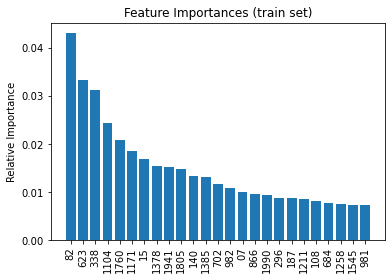

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69670
         1.0       0.95      1.00      0.98        41

    accuracy                           1.00     69711
   macro avg       0.98      1.00      0.99     69711
weighted avg       1.00      1.00      1.00     69711



In [63]:
#get the index of the features (of RDkit fingerprint) that were important
importances = rf.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()
#output metrics
print(classification_report(y_test, y_pred))


In [43]:
#RG, regressor with scaled activity values (drop zeros)
#now train the regressor, which is to predict the activity value itself
#takes about 1 hour to run
rg_scaled=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_scaled.fit(np.asarray(X_train), np.asarray(y2_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 21.7min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [17]:
#bloc for some hyperparameter tuning
#to add stuff later
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rg_scaled.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 111,
 'verbose': 2,
 'warm_start': False}


In [35]:
#RG_unsc, regressor with UNSCALED activity values
#first drop nans
nan_array=np.isnan(y2_train_u)
X_train_u=X_train_u[~nan_array]
y2_train_u=y2_train_u[~nan_array]
rg=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg.fit(np.asarray(X_train_u), np.asarray(y2_train_u))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 72.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [37]:
X_test_reg=fps_merged[test]
X_train_reg=np.concatenate((fps_merged[train], fps_merged[92::]))
y2_train_reg=np.concatenate((ac_merged[train], ac_merged[92::]))
y2_test_reg=ac_merged[test]
nan_array=np.isnan(y2_train_reg)
X_train_reg=X_train_reg[~nan_array]
y2_train_reg=y2_train_reg[~nan_array]

X_test_reg_scaled=fps_merged_scaled[test]
X_train_reg_scaled=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::]))
y2_train_reg_scaled=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::]))
y2_test_reg_scaled=ac_merged_scaled[test]

rg_pos_only=RandomForestRegressor(verbose=2, n_estimators=50, random_state=111)
rg_pos_only_scaled=RandomForestRegressor(verbose=2, n_estimators=50, random_state=111)
rg_pos_only.fit(np.asarray(X_train_reg), np.asarray(y2_train_reg))
rg_pos_only_scaled.fit(np.asarray(X_train_reg_scaled), np.asarray(y2_train_reg_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [74]:
#predict
#scaled data, regression on all
y_pred_regr=rg.predict(X_test_u)
from sklearn.metrics import r2_score
print(r2_score(y2_test_u, y_pred_regr))

#unscaled data, regression on all
y_pred_regr_scaled=rg_scaled.predict(X_test)
print(r2_score(y2_test, y_pred_regr_scaled))

#scaled data, regression on positives
y_pred_regr_pos=rg.predict(X_test_reg)
print(r2_score(y2_test_reg, y_pred_regr_pos))

#unscaled data, regression on positives
y_pred_regr_scaled_pos=rg.predict(X_test_reg_scaled)
print(r2_score(y2_test_reg_scaled, y_pred_regr_scaled_pos))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


0.5801356533109836


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.5854820682375159
0.3446765309783011
0.3446765309783011


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [9]:
#y_pred_reg_noneg=rg.predict(X_test_reg)
#print(r2_score(y2_test_reg, y_pred_reg_noneg))

-0.38381997637138743


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


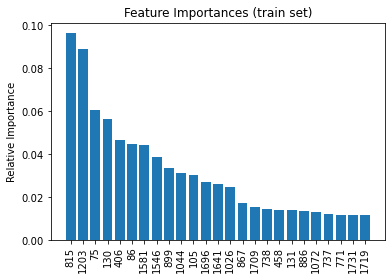

In [90]:
importances = rg.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

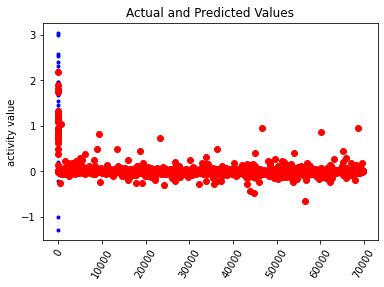

In [76]:
# Dataframe with predictions and dates
plt.plot(y2_test, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

# Graph labels
plt.ylabel('activity value'); plt.title('Actual and Predicted Values');

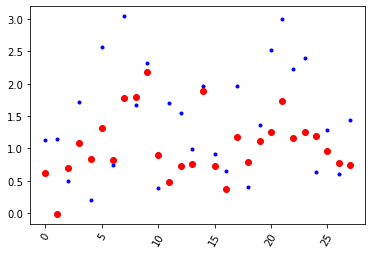

In [39]:
plt.plot(y2_test[y2_test>0], 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr[y2_test>0], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

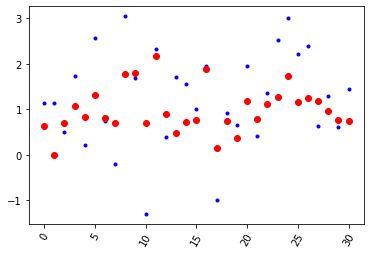

In [40]:
plt.plot(y2_test_reg, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

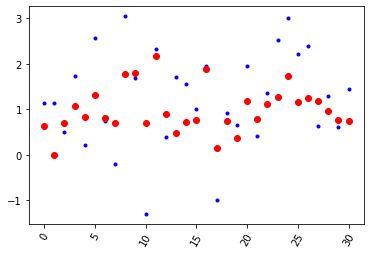

In [42]:
plt.plot(y2_test_reg_scaled, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_scaled_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

In [45]:
#now fit everything
rg_all=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all.fit(np.asarray(X_train_all), np.asarray(y2_train_all))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 42.4min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [60]:
reframe=np.load('../dumps/reframe_fp.npz')
molnames=reframe['arr_1']
reframe=reframe['arr_0']

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['CU-2010' 'Sepimostat mesilate' 'Gabexate' 'Camostat' 'GS-9256'
 'probucol' 'Sovaprevir' 'Deldeprevir' 'BMS-605339' 'Voxilaprevir'
 'Ciluprevir' 'ZD-0892' 'BAY-85-8501' 'Betrixaban' 'LY-517717' 'SN-429'
 'Razaxaban ' 'melagatran' 'ximelagatran' 'dabigatran' 'Flovagatran'
 'Eribaxaban' 'Darexaban' 'Danoprevir' 'Vaniprevir' 'Glecaprevir'
 'Furaprevir' 'Narlaprevir' 'Vedroprevir' 'Faldaprevir' 'IDX-320'
 'Grazoprevir' 'MK-6325' 'MK-1220' 'MK-2748' 'MK-8831' 'Paritaprevir'
 'Simeprevir' 'GS-9132' 'YM-75466' 'Fidexaban' 'rivaroxaban' 'RWJ-58643'
 'WX-UK1' 'Telaprevir' 'Odiparcil' 'JNJ-10326017' 'Midesteine' 'apixaban'
 'Asunaprevir' 'Nafamostat' 'boceprevir' 'meclozine' 'Mitoxantrone'
 'Epicatechin' 'Talabostat' 'ebselen' 'ellagic acid'
 'Epigallocatechin gallate' 'LF-22-0542' 'fradafiban' 'lefradafiban'
 'Ono-3307' 'Patamostat' 'BCX-170' 'Avoralstat' 'BMS-654457' 'BMS-26

In [58]:
predicted_activity=rg_all.predict(reframe)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[['rivaroxaban']
 ['PCI-27483']
 ['KFA-1829']
 ['Ro-43-5054']
 ['SC 52012']
 ['Anatibant']
 ['Ro-43-8857']
 ['Upamostat']
 ['FR-158999']]
[[2.06550801]
 [3.06142707]
 [3.96391463]
 [2.29006854]
 [2.31510403]
 [4.77756466]
 [2.11734183]
 [2.14412795]
 [2.40163713]]


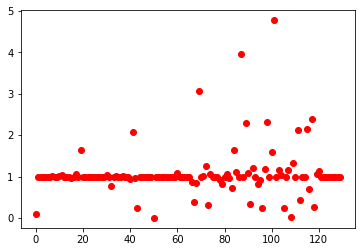

In [73]:
plt.plot(10**-(predicted_activity), 'ro', label = 'prediction')
predicted_activity=10**-(predicted_activity)
indices=np.argwhere(predicted_activity>=2)
print(molnames[indices])
print(predicted_activity[indices])

In [77]:
rg_all2=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all2.fit(np.asarray(fps_merged_scaled), np.asarray(ac_merged_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [78]:
predicted_activity2=rg_all2.predict(reframe)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[['Ro-43-5054']
 ['SC 52012']
 ['FR-144633']]
[[5.53003602]
 [5.44729401]
 [7.47069472]]


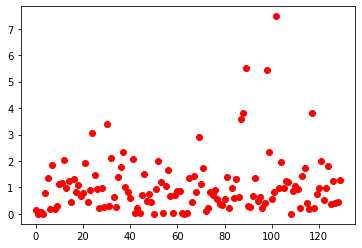

In [83]:
plt.plot(10**-(predicted_activity2), 'ro', label = 'prediction')
predicted_activity2=10**-(predicted_activity2)
indices=np.argwhere(predicted_activity2>=5)
print(molnames[indices])
print(predicted_activity[indices])

In [81]:
nan_array=np.isnan(ac_merged)
fps_merged=fps_merged[~nan_array]
ac_merged=ac_merged[~nan_array]

In [82]:
rg_all3=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all3.fit(np.asarray(fps_merged), np.asarray(ac_merged))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

[['Ro-43-5054']
 ['SC 52012']
 ['FR-144633']]
[[5.53003602]
 [5.44729401]
 [7.47069472]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


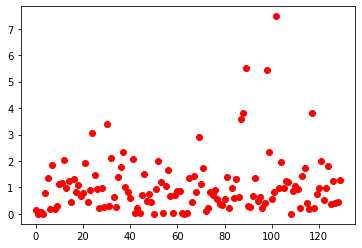

In [85]:
predicted_activity3=rg_all2.predict(reframe)
plt.plot(10**-(predicted_activity3), 'ro', label = 'prediction')
predicted_activity3=10**-(predicted_activity3)
indices=np.argwhere(predicted_activity3>=5)
print(molnames[indices])
print(predicted_activity[indices])